## Forward Euler, continued

First, revisit the simulations with large time steps. On the board, we determined that, in order for the simulation to be constantly shrinking, that the time step should be < 1. 

Let's try that with our single-state degradation model. Here is copy-pasted code from Tuesday.

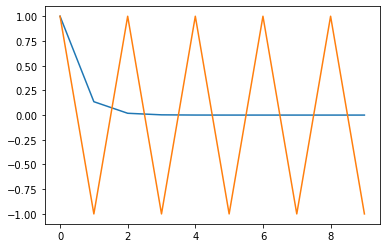

In [3]:
# Run the 1D model to see where the steps break down..
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

def degradation_model1D( t, y, params ):
    dydt = -params[0] * y;
    return dydt

def forwardEuler1D( fn, t, y0, params ):
    """ [t,y] = forwardEuler1D( fn, t, y0, params )
    Given a function handle fn for dydt, find the value of
    y at timepoints t, given y(0) = y0.
    fn takes t, y, and params as input.
    t is 1-dimensional (NT,)
    y is 2-dimensional (1,NT) (NOTE WE ASSUME WE HAVE JUST ONE VARIABLE)
    """
    y = np.zeros( (1,t.size) )
    y[0,0] = y0;
    for i in range(1,t.size):
        h = t[i]-t[i-1];
        yprime = fn(t[i-1],y[0,i-1],params);
        y[0,i] = y[0,i-1] + h*yprime;
    
    return (t,y)

dt = 1
y0 = 1
params = (2,)
t = np.arange(0,10,dt)
tru_y = np.exp( -params[0]*t)
(t,y) = forwardEuler1D( degradation_model1D, t, y0=y0, params=params)

plt.plot(t, tru_y)
plt.plot(t, y.T);

### Rewrite the forward Euler method to work for multi-state models

Rewrite the method so that y0 can have more than one value and fn can return a vector of more than one value.

The return value should be NY x NT (number of states by number of time steps) big, so it gets filled in one column at a time. Adjust the 1D code to account for multiple states.

In [4]:
import numpy as np
def forwardEuler( fn, t, y0, params ):
    """ [t,y] = forwardEuler( fn, t, y0, params )
    Given a function handle fn for dydt, find the value of
    y at timepoints t, given y(0) = y0.
    fn takes t, y, and params as input.
    t is 1-dimensional (NT,)
    y is 2-dimensional (NY,NT)
    """
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0;
    for i in range(1,t.size):
        h = t[i]-t[i-1];
        yprime = fn(t[i-1],y[:,i-1],params);
        y[:,i] = y[:,i-1] + h*yprime;
    
    return (t,y)


Now, make a 2-state degradation model.

In [5]:
def degradation_model( t, y, params ):
    y1 = y[0]
    y2 = y[1]
    dydt = np.zeros( (2,) )
    dydt[0] = -params[0] * y1
    dydt[1] = -params[1] * y2
    return dydt

### Run the 2-state degradation model with forward Euler.

Use 2 and 2.5 as the degradation rates. Simulate from t=0 to t=4 with a time step size of 0.1.

Then plot the true solution and the approximate solution (indicate simulated with dashed lines). And in another plot, show the difference (between the true and approximate solutions) over time.

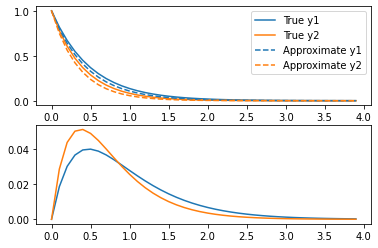

In [6]:
import matplotlib.pyplot as plt

params = np.array([2,2.5])
y0 = np.array([1,1])
(t,y) = forwardEuler( degradation_model, np.arange(0,4,0.1), y0, params)
tru_y1 = y0[0]*np.exp(-params[0]*t)
tru_y2 = y0[1]*np.exp(-params[1]*t)

plt.subplot(2, 1, 1)
plt.plot( t, tru_y1)
plt.plot( t, tru_y2 )
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( t, y.T, '--' );
plt.legend(['True y1','True y2','Approximate y1','Approximate y2']);

plt.subplot( 2, 1, 2 )
plt.plot( t, tru_y1 - y[0,:])
plt.plot( t, tru_y2 - y[1,:]);


### Determine how the error depends on the step size

When we compute the difference between the true and approximate solutions, we have one value at each state for each time step. I would like to summarize this as one number, so that we can plot "error" versus step size.

Let's explore different measures for the error.

In [7]:
import scipy.linalg

tru_y = np.vstack( (tru_y1,tru_y2))
d = tru_y - y
print( "1-norm across states, then mean across time", np.mean(scipy.linalg.norm( d, ord=1, axis=0 )) )
print( "2-norm across states, then mean across time", np.mean(scipy.linalg.norm( d, ord=2, axis=0 )) )
print( "inf-norm across states, then mean across time", np.mean(scipy.linalg.norm( d, ord=np.inf, axis=0 )) )
print( "1-norm across states, then max across time", np.max(scipy.linalg.norm( d, ord=1, axis=0 )) )
print( "2-norm across states, then max across time", np.max(scipy.linalg.norm( d, ord=2, axis=0 )) )
print( "inf-norm across states, then max across time", np.max(scipy.linalg.norm( d, ord=np.inf, axis=0 )) )

1-norm across states, then mean across time 0.025902904858696563
2-norm across states, then mean across time 0.018549186024476992
inf-norm across states, then mean across time 0.01460706848790066
1-norm across states, then max across time 0.09120215528866388
2-norm across states, then max across time 0.0650221500659531
inf-norm across states, then max across time 0.051473191171442334


Determine how the error changes with the time step. Plot two figures - one with the simulations and one with the errors. Compute the error using two methods:
- Compute the Euclidean distance between the true solution and the approximate solution (2-norm of the difference) at each time point, then take the mean across time.
- Compute the infinity norm (max value) of the difference between the true solution and the approximate solution  at each time point, then take the mean across time.

Make an array of time steps. For each time step, plot each solution in a separate subfigure, and keep track of the error in an array. Then plot the errors in a second figure, with each error computation in a separate subfigure.

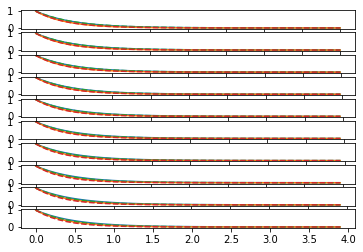

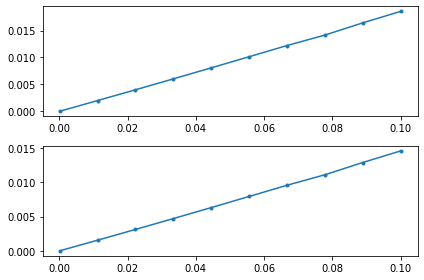

In [8]:
# range from smallest timestep that doesn't take way too long to run to largest time step with qualitatively correct answer.
dts = np.linspace(1e-4,1e-1,10)
err1 = np.zeros( (dts.size,) )
err2 = np.zeros( (dts.size,) )
params = (2,2.5)
y0 = np.array((1,1))

for i in range(dts.size):
    t = np.arange(0,4,dts[i])
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,150), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[params] )
    (t,y) = forwardEuler( degradation_model, t, y0, params)
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.plot( t, y.T, '--')
    err1[i] = np.mean(scipy.linalg.norm( sol.y-y, 2, axis=0) )
    err2[i] = np.mean(scipy.linalg.norm( sol.y-y, np.inf, axis=0) )
    
plt.figure()
plt.subplot(2,1,1)
plt.plot( dts, err1, '.-' );
plt.subplot(2,1,2)
plt.plot( dts, err2, '.-' );
plt.tight_layout()

## Bonus Content

Here, we use Forward Euler to solve the Goodwin oscillator (coded up in Lecture 9). This code is hear as an example to follow when working on Project 3. Aside from being more interesting than the degradation model, the most important difference is that we don't have an analytical solution. So, we use solve_ivp's LSODA method with really tight error controls (i.e. we allow only tiny little errors) to generate the reference "true" solution.

In [9]:
# Here is the model, copied from a notebook from earlier in the course
def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt

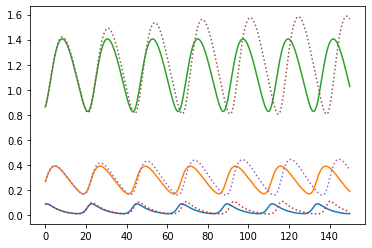

In [10]:
# Simulate the model for a given time step size.
# SRT reran this many times, adjusting the time step.
import scipy.integrate

alpha_1 = 1
K = 0.61
n = 11
gamma_1 = 0.15
alpha_2 = 1
gamma_2 = 0.15
alpha_3 = 1
gamma_3 = 0.25

params = (alpha_1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3)

# Find a point on the limit cycle and start all subsequent simulations from that point.
sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,300), y0=(.1,.1,.1), method='LSODA', rtol=1e-8, atol=1e-8, args=[params] )
y0 = sol.y[:,-1]

# Run this with a time step of 0.1 (which is the biggest that looks like it is still qualitatively correct)
# Run this with a smaller time step - the smallest you are willing to wait for, as well. 
t = np.arange(0,150,.1)
sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,150), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[params] )
(t,y) = forwardEuler( goodwin_oscillator, t, y0, params)

plt.plot( sol.t, sol.y.T );
plt.plot( t, y.T, ':' );

Determine how the error changes with the time step. Since we don't know exactly what the region of absolute stability is, we want to make sure we plot every solution (and not just the error we compute from it). So plot each solution in one figure, but keep track of the error in an array. Then plot the error in a second figure. Here, I compute the error by first computing the Euclidean distance between the true solution and the approximate solution at each time point, then take the mean across time.

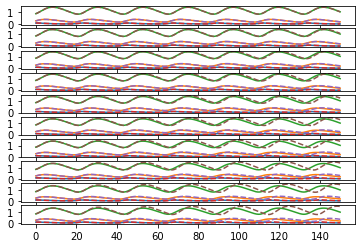

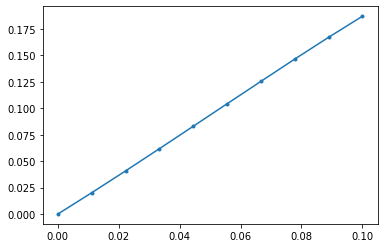

In [11]:
# Determine how the error changes with the time step.
# range from smallest timestep that doesn't take way too long to run to largest time step with qualitatively correct answer.
dts = np.linspace(1e-4,1e-1,10)
err = np.zeros( (dts.size,) )

for i in range(dts.size):
    t = np.arange(0,150,dts[i])
    sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,150), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[params] )
    (t,y) = forwardEuler( goodwin_oscillator, t, y0, params)
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.plot( t, y.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y, 2, axis=0) )
    
plt.figure()
plt.plot( dts, err, '.-' );